# Open Traffic Reporter: Map-Matching Validation

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
cityName = 'San Francisco'

## 1. Generate Random Routes

#### Using Mapzen Venues (requires good WOF coverage)

In [4]:
# routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

#### Using Google Maps POIs (better for non-Western capitals)

In [4]:
# routeList = val.get_POI_routes_by_length(cityName, 1, 5, 10, gmapsKey)

#### Or load a specific set of routes you've already saved

In [3]:
routeList = pickle.load(open('{0}_100_routes.pkl'.format(cityName),'rb'))

#### Optionally save route list for future use

In [9]:
pickle.dump(routeList, open('{0}_10_routes.pkl'.format(cityName),'wb'))

## 2. Iterate Through Routes and Score the Matches

In [4]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]

In [4]:
matchDf, speedDf = val.get_route_metrics(routeList, sampleRates, noiseLevels)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [9]:
# matchDf.to_csv('sf_100_matches.csv', index=False)

In [10]:
# speedDf.to_csv('sf_100_speeds.csv', index=False)

In [5]:
matchDf = pd.read_csv('sf_100_matches.csv')

speedDf = pd.read_csv('sf_100_speeds.csv')

### Check for Pattern Failure 

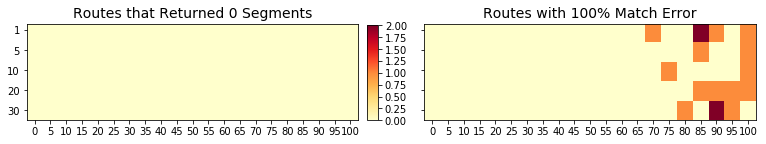

In [6]:
val.plot_pattern_failure(matchDf, sampleRates, noiseLevels)

## 3. Visualize the Scores

### Distance-based Metrics

##### A measure of distance-based map matching error borrowed from [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf):

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>

Plots in the left column below represent match scores based solely on segment ID, where "undermatches" denote the percentage of segments in the original route not identified during map matching (false negatives), and "overmatches" refer to segments identified during map matching that were not a part of the original route (false positives). The right-hand column shows the same metrics as the left, but weighted by segment length as a percentage of the total route trace. In other words, for the distance-weighted metrics, a mismatched segment 2 km in length penalizes the match score by twice as much as a 1 km segment. 

For reference, the graph on the top right ("distance traveled") corresponds to Newton and Krumm's (2009) metric as depicted in the image above. We will return to this metric later for use in optimizing the map-matching algorithm.

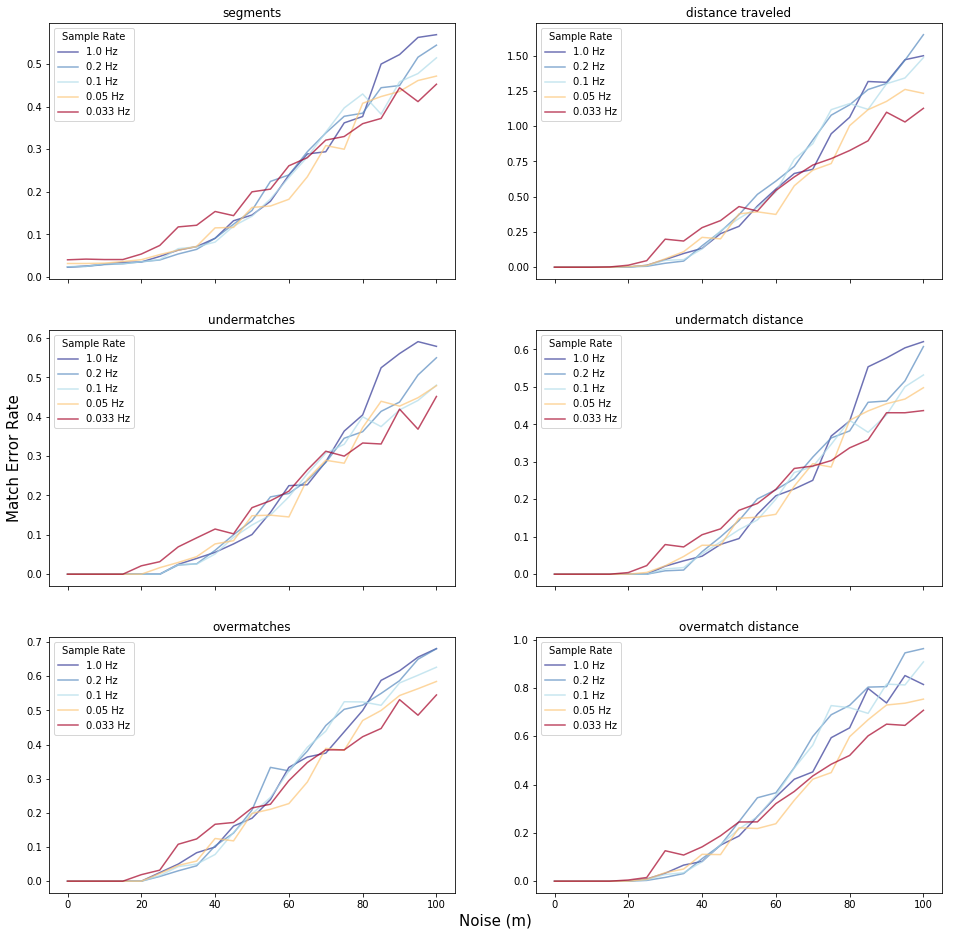

In [7]:
val.plot_distance_metrics(matchDf, sampleRates)

Worth noting are the very consistent points of inflection about which error for low sample rate GPS traces (red) improves relative to that of higher sample rate measurements (blue). The inflection point occurs at ~70 m of noise across almost all of our metrics, and is consistent with the findings of Newton and Krumm (2009). These results suggest that lower sample rates tend to be more robust against mismatch error at higher levels of noise (> 60 m).

## 4. Optimize Map-Matching Parameters

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). Skipping over 99% of the innerworkings of HMMs, there are two probability-related parameters in the HMM algorithm that should be estimated from data (for more detail see [here](https://en.wikipedia.org/wiki/Hidden_Markov_model)):

## $\sigma_z$

The first parameter that needs tuning is $\sigma_z$. It appears in the equation below which expresses the probability of recording the GPS measurement $z_t$ from road segment $r_i$, where $x_{t,i}$ is the point on road segment $r_i$ nearest the measurement $z_t$. 

### $$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$

In practice, $\sigma_z$ can be thought of as an estimate of the standard deviation of the GPS noise. The more we trust our measurements, the lower our $\sigma_z$ should be. Newton and Krumm (2009) derive their value of $\sigma_z$ from the median absolute deviation over their dataset, arriving at a value of 4.07 m. 

## $\beta$

The second estimated parameter, $\beta$, comes from the exponential distribution. Newton and Krumm found that the distribution of differences between "great circle" distances (also known as "as-the-crow-flies" distance) and map-matched route distance traveled closely resembles that of an exponential probability distribution: 

### $$p(d_t) = \frac{1}{\beta}e^{\frac{-d_t}{\beta}} $$

where $d_t$ is the difference between the great circle distance and route distance traveled between time $t$ and $t+1$, and $\beta$ is the "scale" parameter (or inverse rate) of the exponential distribution. In this context, $\beta$ can be thought of as the expected difference between great circle distances and route distance traveled. Newton and Krumm use a different robust estimator taken from statistics literature to estimate this value from data.

### Grid search to find optimal parameter values

An alternative to explicitly estimating these values from data is search the feasible parameter space and store the values that result in the optimal match scores. This is a common approach for algorithm optimization, typically referred to as a grid search or parameter sweep. Here, we perform a grid search for each of our specified sample rates so that we can store the optimal parameter values for each one.

Note: because GPS noise cannot be controlled in a top down way (as opposed to sample rate), our parameter values for a given sample rate will be optimized over the entire range of noise: 0 to 100 m.

In [ ]:
noiseLevels = np.linspace(0, 100, 6)
# noiseLevels = [50]
sampleRates = [1, 5, 10, 20, 30]
# sampleRates = [10]
betas = np.arange(0.5, 10.5, 0.5)
sigmaZs = np.arange(0.5, 10.5, 0.5)
paramDf = val.grid_search_hmm_params(cityName, routeList, sampleRates, noiseLevels, betas, sigmaZs)

Processing route 1 of 100
Computing score for sigma_z: 0.5, beta: 0.5
Computing score for sigma_z: 1.0, beta: 0.5
Computing score for sigma_z: 1.5, beta: 0.5
Computing score for sigma_z: 2.0, beta: 0.5
Computing score for sigma_z: 2.5, beta: 0.5
Computing score for sigma_z: 3.0, beta: 0.5
Computing score for sigma_z: 3.5, beta: 0.5
Computing score for sigma_z: 4.0, beta: 0.5
Computing score for sigma_z: 4.5, beta: 0.5
Computing score for sigma_z: 5.0, beta: 0.5
Computing score for sigma_z: 5.5, beta: 0.5
Computing score for sigma_z: 6.0, beta: 0.5
Computing score for sigma_z: 6.5, beta: 0.5
Computing score for sigma_z: 7.0, beta: 0.5
Computing score for sigma_z: 7.5, beta: 0.5
Computing score for sigma_z: 8.0, beta: 0.5
Computing score for sigma_z: 8.5, beta: 0.5
Computing score for sigma_z: 9.0, beta: 0.5
Computing score for sigma_z: 9.5, beta: 0.5
Computing score for sigma_z: 10.0, beta: 0.5
Computing score for sigma_z: 0.5, beta: 1.0
Computing score for sigma_z: 1.0, beta: 1.0
Compu

In [ ]:
val.plot_param_scores(paramDf, sampleRates, noiseLevels, betas, sigmaZs)

### Speed-based Metrics

Mapzen's map-matching algorithm relies on a kind of graphical model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic in nature, the match returned by the algorithm will always be a best guess. However, this best guess may still be far from the "truth". Thus, we want some method for filtering out match results that just aren't realistic. 

Derived segment speeds provide us with one such method for throwing out bad results. Although GPS positional data is often very noisy, its temporal measurements are rarely wrong. Comparing the time (speed) it takes for an agent to traverse a segment to the known speed limit along that segment can provide a very accurate way to filter out erroneous matches.

Below, we attempt to learn from our simulated GPS traces what an optimal speed-error threshold might be for creating such a filter.

#### Calculate and plot the optimal speed error threshold

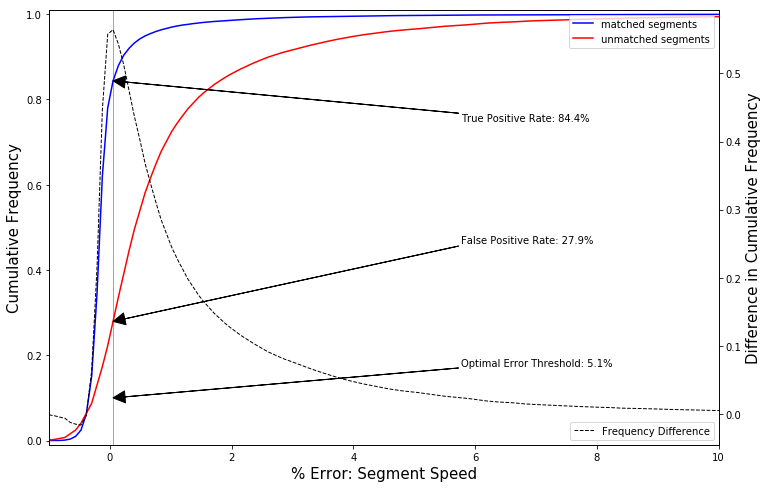

In [13]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

#### Map Matching Accuracy Using One-Size-Fits-All Speed Error Threshold

Statistical accuracy measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively.

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches Kept} \ + \ \text{# Misses Discarded}}{\text{# Segments}}$$

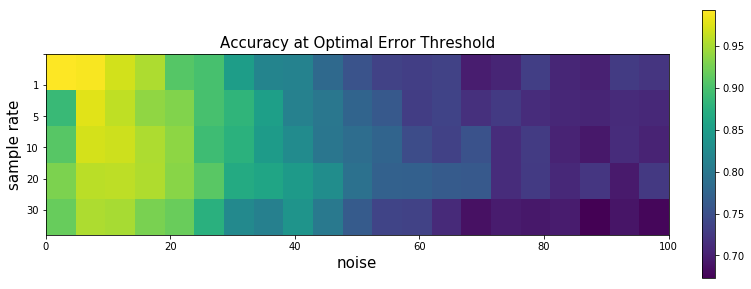

In [14]:
oneSizeFitsAll = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels)

#### Calculate optimal thresholds for each sample rate

GPS sample rate is likely to be fixed for a given data provider. We can thus tune our cutoff threshold based on the sample rate which should improve the accuracy of our matches overall.

In [15]:
thresholdsByRate = []
for rate in sampleRates:
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)

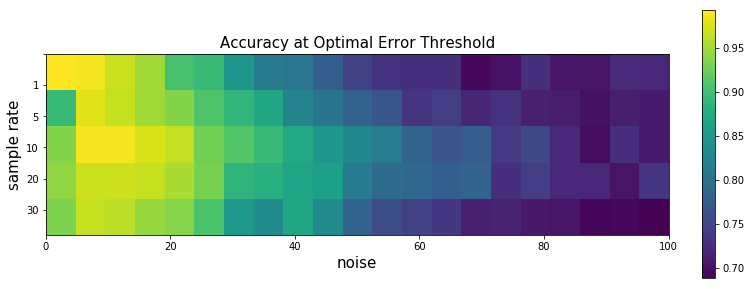

In [16]:
accBySampleRate = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels)

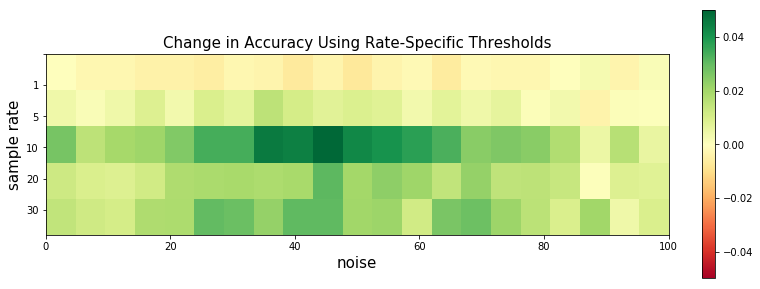

In [17]:
val.plot_change_in_acc(oneSizeFitsAll, accBySampleRate, sampleRates, noiseLevels)

Prior knowledge of expected GPS sample rate can result in accuracy gains of up to 5%.

## 5. Generate Testing Data

In [1]:
testRouteList = val.get_routes_by_length(cityName, 1, 5, 10, mapzenKey)

NameError: name 'val' is not defined

## 6. Visualize Routes

In [9]:
geojsonList = [trace for trace in os
               .listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

In [99]:
fname

'../data/trace_Richard Naidus MD_to_Krutman Electronic Systems Inc_w_100.0_m_noise_at_0.1_Hz.geojson'

In [100]:
matchDf.loc[(
    matchDf['noise'] == 100) & (
    matchDf['sample_rate'] == 10) & (
    matchDf['route'] == "Richard Naidus MD_to_Krutman Electronic Systems Inc"),'reporter_url'].values[0]

u'http://reporter:8003/report?json=%7B%22match_options%22%3A%7B%22turn_penalty_factor%22%3A500%2C%22sigma_z%22%3A4.07%2C%22breakage_distance%22%3A2000%2C%22search_radius%22%3A50%2C%22beta%22%3A3%2C%22gps_accuracy%22%3A100.0%2C%22mode%22%3A%22auto%22%7D%2C%22shape_match%22%3A%22map_snap%22%2C%22uuid%22%3A%22999999%22%2C%22trace%22%3A%5B%7B%22lat%22%3A37.789387%2C%22lon%22%3A-122.418033%2C%22time%22%3A1499633519%7D%2C%7B%22lat%22%3A37.788516%2C%22lon%22%3A-122.41808%2C%22time%22%3A1499633529%7D%2C%7B%22lat%22%3A37.787693%2C%22lon%22%3A-122.418242%2C%22time%22%3A1499633539%7D%2C%7B%22lat%22%3A37.786956%2C%22lon%22%3A-122.417908%2C%22time%22%3A1499633549%7D%2C%7B%22lat%22%3A37.786133%2C%22lon%22%3A-122.417633%2C%22time%22%3A1499633559%7D%2C%7B%22lat%22%3A37.784964%2C%22lon%22%3A-122.417504%2C%22time%22%3A1499633569%7D%2C%7B%22lat%22%3A37.783848%2C%22lon%22%3A-122.417245%2C%22time%22%3A1499633579%7D%2C%7B%22lat%22%3A37.78296%2C%22lon%22%3A-122.417099%2C%22time%22%3A1499633589%7D%2C%7B%22lat

## 6. Save Match Scores to Master File

In [20]:
matchDf.columns = [x.strip().replace(' ', '_') for x in df.columns]
matchDf.to_csv('../data/master_scores.csv', index=False)